In [1]:
import numpy as np
import astropy.io.fits as fitsio
import matplotlib.pyplot as plt 
from astropy.table import Table, vstack
import desimodel.io
import os
%matplotlib inline

In [2]:
def random_patch(n_dens=2500, plate_radius=1.61):
    """Generates a random set of points within a single plate.
    n_dens: number density of the random points to be generated
    plate_radius: radius of DESI plate in degrees.
    """
    n_total = int(4.0* n_dens * plate_radius**2)
    
    #The points are generated on a "square" centered around theta=pi/2 and phi=pi (spherical coordinates)
    phi = 2.0*(np.random.random(n_total) - 0.5) * np.deg2rad(plate_radius)
    costheta = 2.0*(np.random.random(n_total)-0.5) * np.deg2rad(plate_radius)
    theta = np.arccos(costheta) 
    
    #We now select the points inside the circle
    mu = np.cos(phi) * np.sin(theta) # dot product between each point and unit vector along x
    inside = np.abs(mu) > np.cos(np.deg2rad(plate_radius)) 
    return {'RA':np.rad2deg(np.pi - phi[inside]), 'DEC':np.rad2deg(theta[inside]-np.pi/2.0)}

def fill_columns(input_dict, priority=100):
    """Writes a tile file with a single tile.
    """
    column_vals = {'DESI_TARGET':1,
               'MWS_TARGET':0,
               'BGS_TARGET':0, 
               'OBSCONDITIONS':1, 
               'BRICKNAME':'180d000',
               'SUBPRIORITY':0,
               'NUMOBS_MORE':2,
               'PRIORITY':priority}
    
    n_points = len(input_dict['RA'])
    for k in column_vals.keys():
        if k not in input_dict.keys():
            if k=='SUBPRIORITY':
                input_dict[k] = np.random.random(n_points)
            else:
                input_dict[k] = np.repeat(column_vals[k], n_points)
    return input_dict

def write_targets(n_target_dens=800, n_sky_dens=1200, n_star_dens=120, only_write_mtl=False):
    """Generates mtl, sky and star files.
    """
    target_points = random_patch(n_dens=n_target_dens)
    sky_points = random_patch(n_dens=n_sky_dens)
    star_points = random_patch(n_dens=n_star_dens)

    n_target = len(target_points['RA'])
    n_sky = len(sky_points['RA'])
    n_star = len(star_points['RA'])
    n_tot = n_target +n_sky + n_star
    id_list = np.arange(n_tot)
    target_points['TARGETID'] = id_list[:n_target]
    sky_points['TARGETID'] = id_list[n_target:n_target+n_sky]
    star_points['TARGETID'] = id_list[-n_star:]

    target_points = fill_columns(target_points, priority=100)
    sky_points = fill_columns(sky_points, priority=10)
    star_points = fill_columns(star_points, priority=10)
    if only_write_mtl:
        Table(target_points).write('mtl.fits', overwrite=True)
    else:
        Table(target_points).write('mtl.fits', overwrite=True)
        Table(sky_points).write('sky.fits', overwrite=True)
        Table(star_points).write('star.fits', overwrite=True)
    return
    
def write_tile(ra=180.0, dec=0.0):
    tile = {'TILEID':[0], 
            'RA': [ra],
            'DEC': [dec],
            'PASS': [0],
            'IN_DESI': [1],
            'EBV_MED': [0.0],
            'AIRMASS': [1.0],
            'STAR_DENSITY': [1.0],
            'EXPOSEFAC': [1.0],
            'PROGRAM': ['DARK'],
            'OBSCONDITIONS': [1] }
    Table(tile).write('tile.fits', overwrite=True)
    return
def write_survey():
    """Write the list of tiles to be fiberassigned.
    """
    fx = open('surveytiles.txt', 'w')
    fx.write("0\n")
    fx.close()
    

def write_config(mtlfile="mtl.fits", 
                      stdfile="star.fits", 
                      skyfile="sky.fits", 
                      surveytiles="surveytiles.txt", 
                      outdir="./", 
                      tilefile="tile.fits", 
                      fibfile="./"):
    """Writes the configuration file for fiberassign.
    """
    template = """
    Targfile {mtlfile}
    SStarsfile {stdfile}
    SkyFfile  {skyfile}
    surveyFile {surveytilesfile}
    outDir {outdir}
    tileFile {tilefile}
    fibFile {fiberposfile}
    PrintAscii false
    PrintFits true
    diagnose true
    kind QSOLy-a QSOTracer LRG ELG FakeQSO FakeLRG SS SF
    type QSO QSO LRG ELG QSO LRG SS SF
    prio 3400 3400 3200 3000 3400 3200 0 0
    priopost 3500 0 3200 0 0 0 0 0
    goal 5 5 2 1 5 2 5 5
    goalpost 5 1 2 1 1 1 5 5
    lastpass 0 0 0 1 0 0 1 1 
    SS       0 0 0 0 0 0 1 0
    SF       0 0 0 0 0 0 0 1 
    pass_intervals 0 50 100 150 200
    Randomize false
    Pacman false
    Npass 5
    MaxSS 10
    MaxSF 40
    PlateRadius 1.65
    InterPlate 0
    Analysis 0
    InfDens false
    TotalArea 15789.0
    invFibArea 700
    moduloGal 1
    moduloFiber 1
    Collision false
    Exact true
    AvCollide 3.2
    Collide 1.98
    NoCollide 7.0
    PatrolRad 5.8
    NeighborRad 14.05
    PlotObsTime false
    PlotHistLya false
    PlotDistLya false
    PlotFreeFibHist false
    PlotFreeFibTime false
    PlotSeenDens false
    PrintGalObs false
    MinDec -90.
    MaxDec 90.
    MinRa 0.
    MaxRa 360.
    Verif false
    """
    tx = template.format(
    mtlfile = mtlfile,
    stdfile = stdfile,
    skyfile = skyfile,
    surveytilesfile = surveytiles,
    outdir = outdir,
    tilefile = tilefile,
    fiberposfile = desimodel.io.findfile('focalplane/fiberpos.txt'),
    )
    fx = open('fiberassign.cfg', 'w')
    fx.write(tx)
    fx.close()

def run_fiberassign():
    os.system('rm -f tile_00000.fits')
    os.system('fiberassign fiberassign.cfg')

Generates all the data

In [3]:
write_targets()
write_tile()
write_survey()
write_config()
run_fiberassign()

Reads the data

In [4]:
targets = Table.read('mtl.fits')
sky = Table.read('sky.fits')
star = Table.read('star.fits')
alltargets = vstack([targets, sky, star])
obstargets = Table.read('tile_00000.fits', hdu=1)
pottargets = Table.read('tile_00000.fits', hdu=2)

Simple plot showing three different sets of targets

3514 2413 618 6545


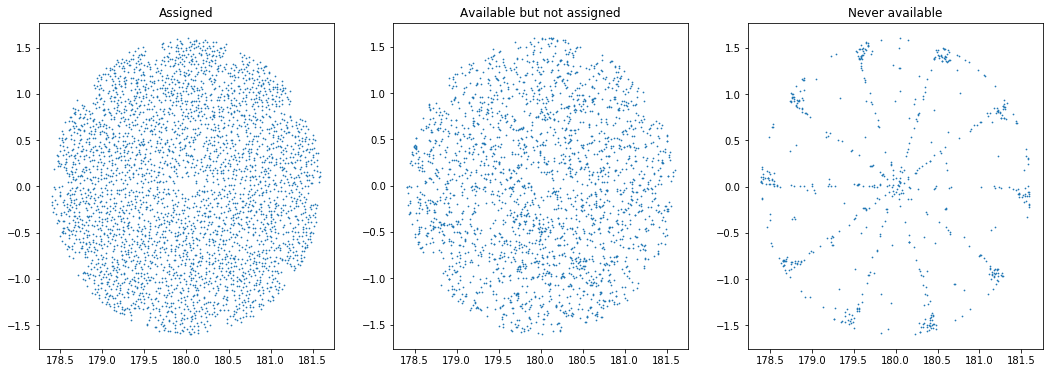

In [5]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.title('Assigned')
ii = np.in1d(targets['TARGETID'], obstargets['TARGETID'])
ii = targets['TARGETID'][ii]
plt.scatter(targets['RA'][ii], targets['DEC'][ii], s=0.5)

n_assigned = len(ii)

plt.subplot(132)
#create a list of unique potential targets excluding the assigned ones.
potunique = np.unique(pottargets['POTENTIALTARGETID'])
jj = np.in1d(potunique, obstargets['TARGETID'], invert=True)
potunique = potunique[jj]

jj = np.in1d(targets['TARGETID'], potunique)
jj = targets['TARGETID'][jj]
plt.scatter(targets['RA'][jj], targets['DEC'][jj], s =0.5)
plt.title('Available but not assigned')
n_available_not_assigned = len(jj)

plt.subplot(133)
kk = np.in1d(targets['TARGETID'], np.concatenate([ii,jj]), invert=True)
kk = targets['TARGETID'][kk]
plt.scatter(targets['RA'][kk], targets['DEC'][kk], s=0.5)
plt.title('Never available')
n_unavailable = len(kk)

print(n_assigned, n_available_not_assigned, n_unavailable, len(targets['TARGETID']))

assert (n_assigned + n_available_not_assigned + n_unavailable)==len(targets['TARGETID'])